# [A]. Explain the mathematical intuition behind Hierarchical Clustering and Density-Based Spatial Clustering (DBSCAN) by providing two examples. One example for each algorithm.

"**DBSCAN**"


 requires two parameters: epsilon (eps) and min_samples. Eps defines the radius of the neighborhood around a point, and min_samples is the minimum number of
 points required to form a dense region."


"Points are classified into core points, border points, and noise points based on these parameters."

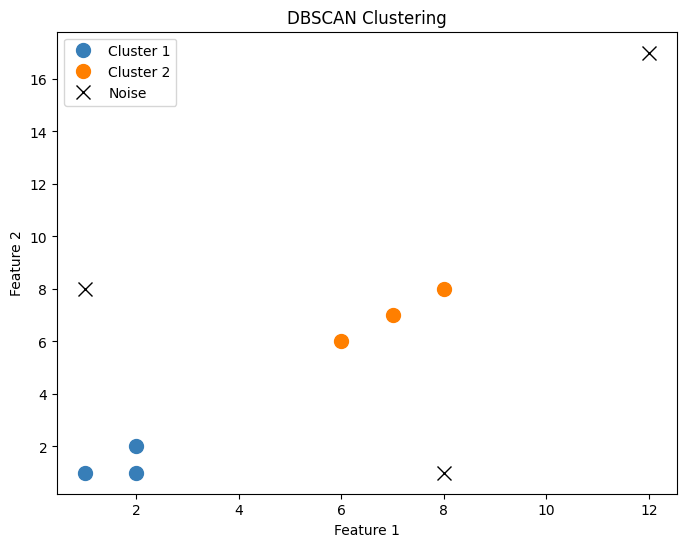

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Example data points with added noise
X = np.array([[1, 1], [2, 2], [2, 1], [6, 6], [7, 7], [8, 8], [1, 8], [8, 1],[12,17]])

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=1.5, min_samples=2)
dbscan.fit(X)

# Extract labels
labels = dbscan.labels_

# Plot the result
plt.figure(figsize=(8, 6))

# Colors for the clusters (use a colormap)
colors = np.array(['#377eb8', '#ff7f00', '#4daf4a', '#e41a1c'])
unique_labels = set(labels)

for k in unique_labels:
    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    if k == -1:
        color = '#000000'
        marker = 'x'
        label = 'Noise'
    else:
        color = colors[k % len(colors)]
        marker = 'o'
        label = f'Cluster {k + 1}'
    plt.plot(xy[:, 0], xy[:, 1], marker, markerfacecolor=color, markeredgecolor=color, markersize=10, label=label)

plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:282: UserWarning: the number of connected components of the connectivity matrix is 8 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:282: UserWarning: the number of connected components of the connectivity matrix is 9 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:282: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:282: UserWarning: the number of connected components of the connectivity matrix is 22 > 1. Completing it to a

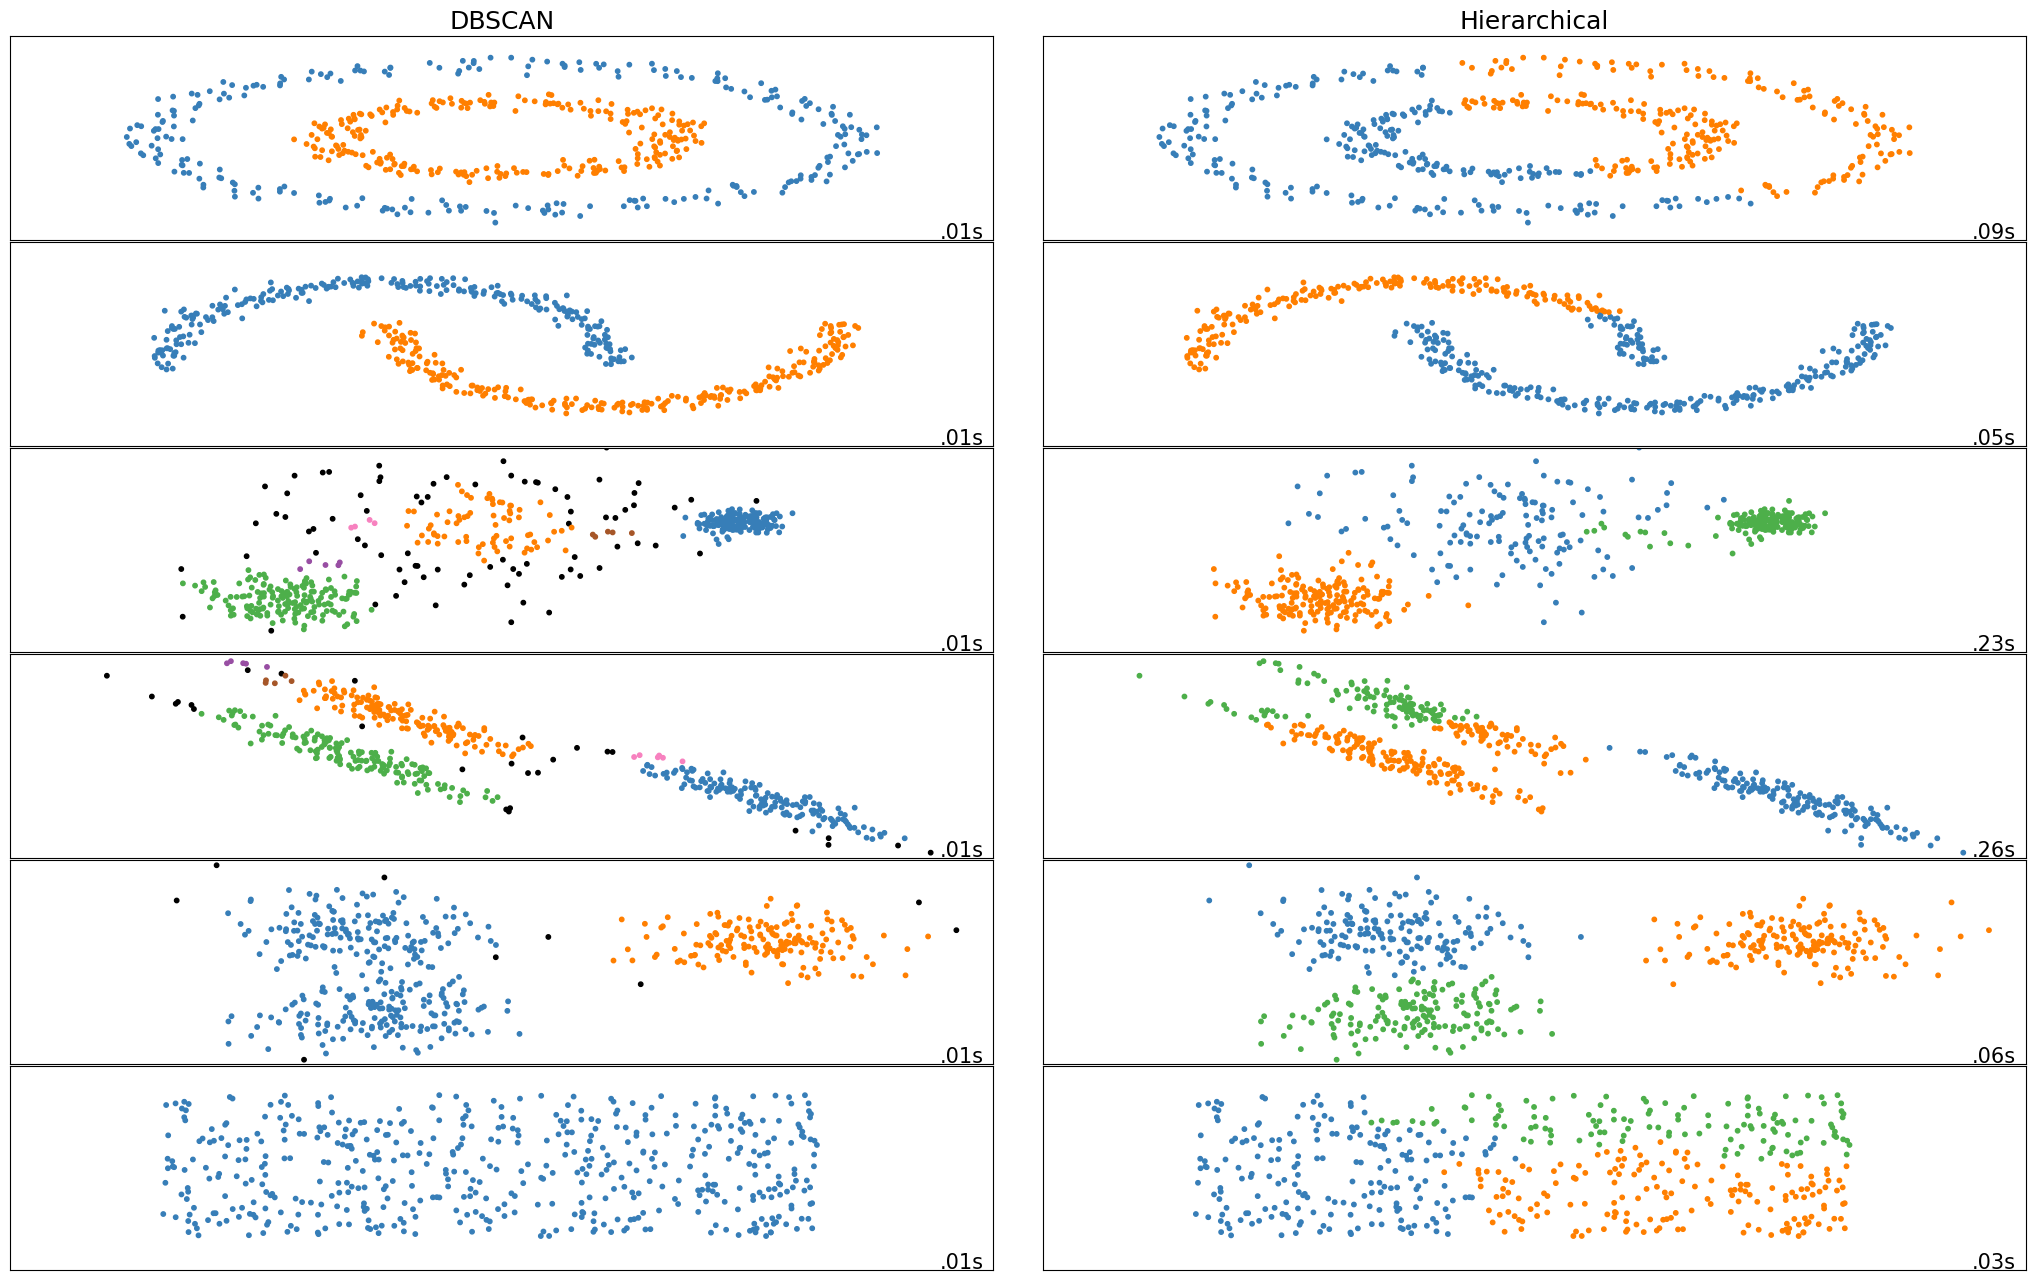

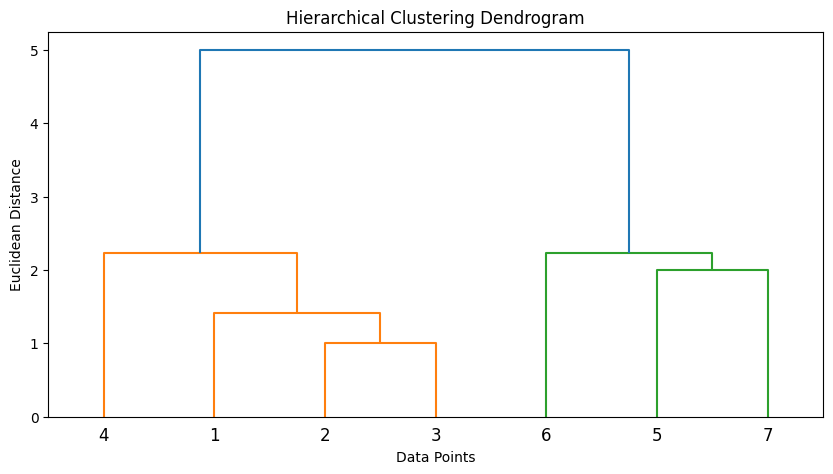

In [ ]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

# ============
# ============
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    dbscan = cluster.DBSCAN(eps=params["eps"])
    hierarchical = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )

    clustering_algorithms = (("DBSCAN", dbscan), ("Hierarchical", hierarchical))

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()


import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

X = np.array([[1, 2], [2, 3], [2, 4], [4, 2], [6, 8], [7, 6], [8, 8]])

linked = linkage(X, 'single')

plt.figure(figsize=(10, 5))
dendrogram(linked, labels=range(1, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance')
plt.show()


**Hierarchical Clustering**



Hierarchical Clustering creates a hierarchy of clusters which can be visualized using a dendrogram."
"There are two types of hierarchical clustering: agglomerative and divisive. We will focus on agglomerative clustering."

"Agglomerative clustering starts with each point as its own cluster and merges the closest pairs step by step until all points form one cluster."
"We calculate the distance between each pair of points using metrics like Euclidean distance."

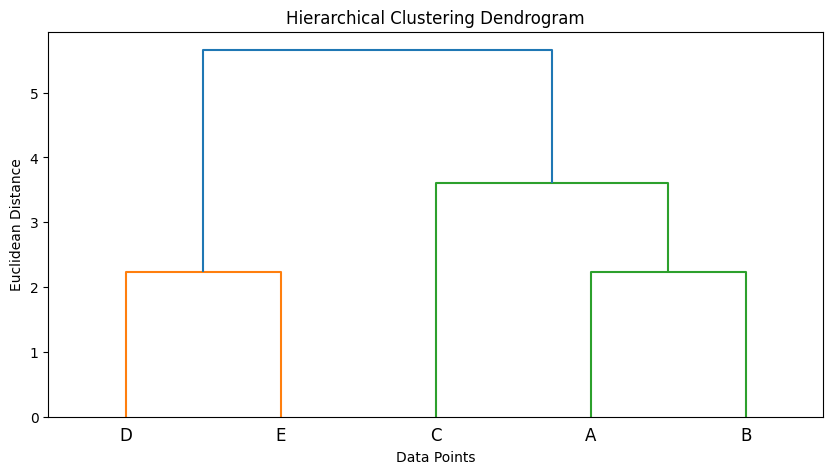

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

X = np.array([[2, 3], [3, 5], [5, 8], [8, 2], [9, 4]])

linked = linkage(X, 'single')

plt.figure(figsize=(10, 5))
dendrogram(linked, labels=['A', 'B', 'C', 'D', 'E'])
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance')
plt.show()


**Conclusion and Summary**

"In summary, Hierarchical Clustering builds a hierarchy of clusters and is useful for visualizing the merging process with a dendrogram."
"DBSCAN identifies clusters based on the density of points, making it effective for datasets with noise and clusters of arbitrary shapes."
"Both algorithms have their strengths and are chosen based on the specific requirements of the data and analysis."

# Clustring on Data Set


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_excel("/content/drive/MyDrive/project 2/Project 2-Due Date: May 18, 2024, before 4 PM/Dataset- Project 2/UnSup-Data-2024.xlsx")
data = data.drop(columns=['ID'])
print(data)

      AGE  EDUC  MARRIED  KIDS  LIFECL  OCCAT  RISK  HHOUSES  WSAVED  \
0       3     2        1     0       2      1     3        1       1   
1       4     4        1     2       5      2     3        0       2   
2       3     1        1     2       3      2     2        1       2   
3       3     1        1     2       3      2     2        1       2   
4       4     3        1     1       5      1     2        1       3   
...   ...   ...      ...   ...     ...    ...   ...      ...     ...   
3861    3     1        1     1       3      1     4        0       2   
3862    3     1        1     1       3      1     4        0       2   
3863    5     1        1     0       5      1     4        0       3   
3864    2     4        1     7       3      1     3        1       3   
3865    3     4        2     0       1      2     2        1       2   

      SPENDMOR  NWCAT  INCCL  
0            5      3      4  
1            5      5      5  
2            4      4      4  
3          

In [ ]:
print("\nMissing Values:")
print(data.isnull().sum())

data.fillna(data.mean(), inplace=True)

print("\nData after filling missing values:")
print(data.head())


Missing Values:
AGE         0
EDUC        0
MARRIED     0
KIDS        0
LIFECL      0
OCCAT       0
RISK        0
HHOUSES     0
WSAVED      0
SPENDMOR    0
NWCAT       0
INCCL       0
dtype: int64

Data after filling missing values:
   AGE  EDUC  MARRIED  KIDS  LIFECL  OCCAT  RISK  HHOUSES  WSAVED  SPENDMOR  \
0    3     2        1     0       2      1     3        1       1         5   
1    4     4        1     2       5      2     3        0       2         5   
2    3     1        1     2       3      2     2        1       2         4   
3    3     1        1     2       3      2     2        1       2         4   
4    4     3        1     1       5      1     2        1       3         3   

   NWCAT  INCCL  
0      3      4  
1      5      5  
2      4      4  
3      3      4  
4      5      5  


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

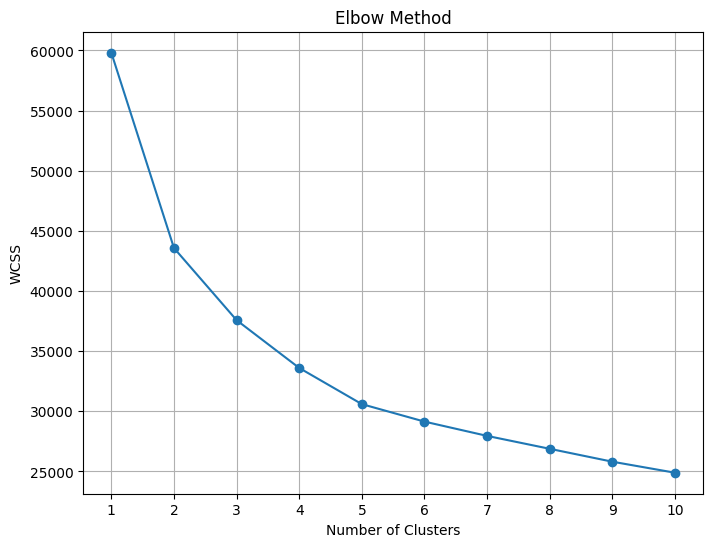

In [ ]:
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.show()


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_clusters = kmeans.fit_predict(data)

data['KMeans_Cluster'] = kmeans_clusters

print("\nK-Means Clustering Results:")
print(data.head())


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



K-Means Clustering Results:
   AGE  EDUC  MARRIED  KIDS  LIFECL  OCCAT  RISK  HHOUSES  WSAVED  SPENDMOR  \
0    3     2        1     0       2      1     3        1       1         5   
1    4     4        1     2       5      2     3        0       2         5   
2    3     1        1     2       3      2     2        1       2         4   
3    3     1        1     2       3      2     2        1       2         4   
4    4     3        1     1       5      1     2        1       3         3   

   NWCAT  INCCL  KMeans_Cluster  
0      3      4               1  
1      5      5               0  
2      4      4               1  
3      3      4               1  
4      5      5               0  


In [ ]:

from sklearn.cluster import AgglomerativeClustering

hierarchical = AgglomerativeClustering(n_clusters=2)
hierarchical_clusters = hierarchical.fit_predict(data)

data['Hierarchical_Cluster'] = hierarchical_clusters

print("\nHierarchical Clustering Results:")
print(data.head())




Hierarchical Clustering Results:
   AGE  EDUC  MARRIED  KIDS  LIFECL  OCCAT  RISK  HHOUSES  WSAVED  SPENDMOR  \
0    3     2        1     0       2      1     3        1       1         5   
1    4     4        1     2       5      2     3        0       2         5   
2    3     1        1     2       3      2     2        1       2         4   
3    3     1        1     2       3      2     2        1       2         4   
4    4     3        1     1       5      1     2        1       3         3   

   NWCAT  INCCL  KMeans_Cluster  Hierarchical_Cluster  
0      3      4               1                     0  
1      5      5               0                     1  
2      4      4               1                     0  
3      3      4               1                     0  
4      5      5               0                     1  


In [ ]:

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5,min_samples=3)
dbscan_clusters = dbscan.fit_predict(data)

data['DBSCAN_Cluster'] = dbscan_clusters

print("\nDBSCAN Clustering Results:")
print(data.head())




DBSCAN Clustering Results:
   AGE  EDUC  MARRIED  KIDS  LIFECL  OCCAT  RISK  HHOUSES  WSAVED  SPENDMOR  \
0    3     2        1     0       2      1     3        1       1         5   
1    4     4        1     2       5      2     3        0       2         5   
2    3     1        1     2       3      2     2        1       2         4   
3    3     1        1     2       3      2     2        1       2         4   
4    4     3        1     1       5      1     2        1       3         3   

   NWCAT  INCCL  KMeans_Cluster  Hierarchical_Cluster      PCA1      PCA2  \
0      3      4               1                     0 -1.106642 -0.018439   
1      5      5               0                     1  2.278484 -1.712447   
2      4      4               1                     0 -0.403681 -0.607583   
3      3      4               1                     0 -0.742971 -0.014759   
4      5      5               0                     1  2.219718 -2.098995   

   DBSCAN_Cluster  
0             

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

features = data.drop(columns=['Hierarchical_Cluster', 'KMeans_Cluster'])

metrics = {
    'Method': ['Hierarchical', 'KMeans'],
    'Silhouette Score': [
        silhouette_score(features, hierarchical_clusters),
        silhouette_score(features, kmeans_clusters),
    ],
    'Davies-Bouldin Index': [
        davies_bouldin_score(features, hierarchical_clusters),
        davies_bouldin_score(features, kmeans_clusters),
    ],
    'Calinski-Harabasz Index': [
        calinski_harabasz_score(features, hierarchical_clusters),
        calinski_harabasz_score(features, kmeans_clusters),
    ]
}

metrics_df = pd.DataFrame(metrics)

print(metrics_df)

         Method  Silhouette Score  Davies-Bouldin Index  \
0  Hierarchical          0.254292              1.537985   
1        KMeans          0.254409              1.537212   

   Calinski-Harabasz Index  
0              1437.746598  
1              1439.883662  


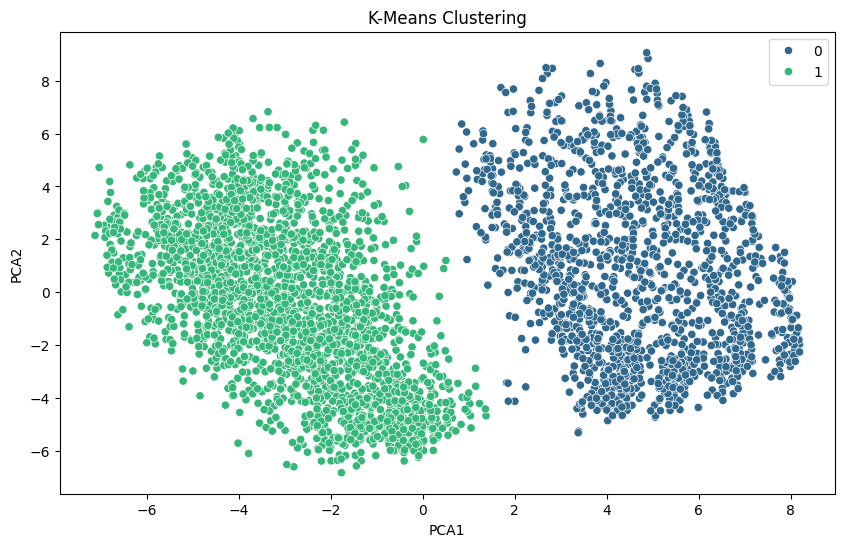

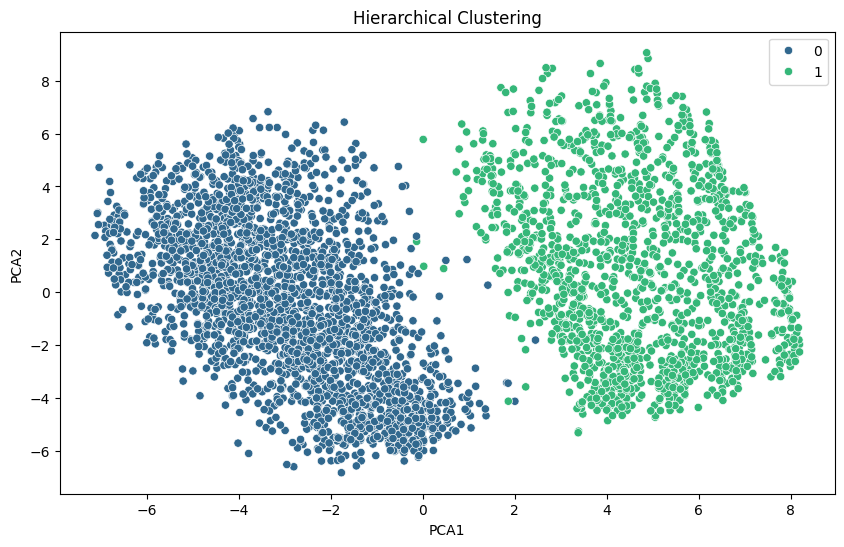

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
def plot_clusters(df, cluster_col, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PCA1', y='PCA2', hue=cluster_col, data=df, palette='viridis')
    plt.title(title)
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    plt.show()


pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)
data['PCA1'] = data_pca[:, 0]
data['PCA2'] = data_pca[:, 1]


plot_clusters(data, 'KMeans_Cluster', 'K-Means Clustering')
plot_clusters(data, 'Hierarchical_Cluster', 'Hierarchical Clustering')


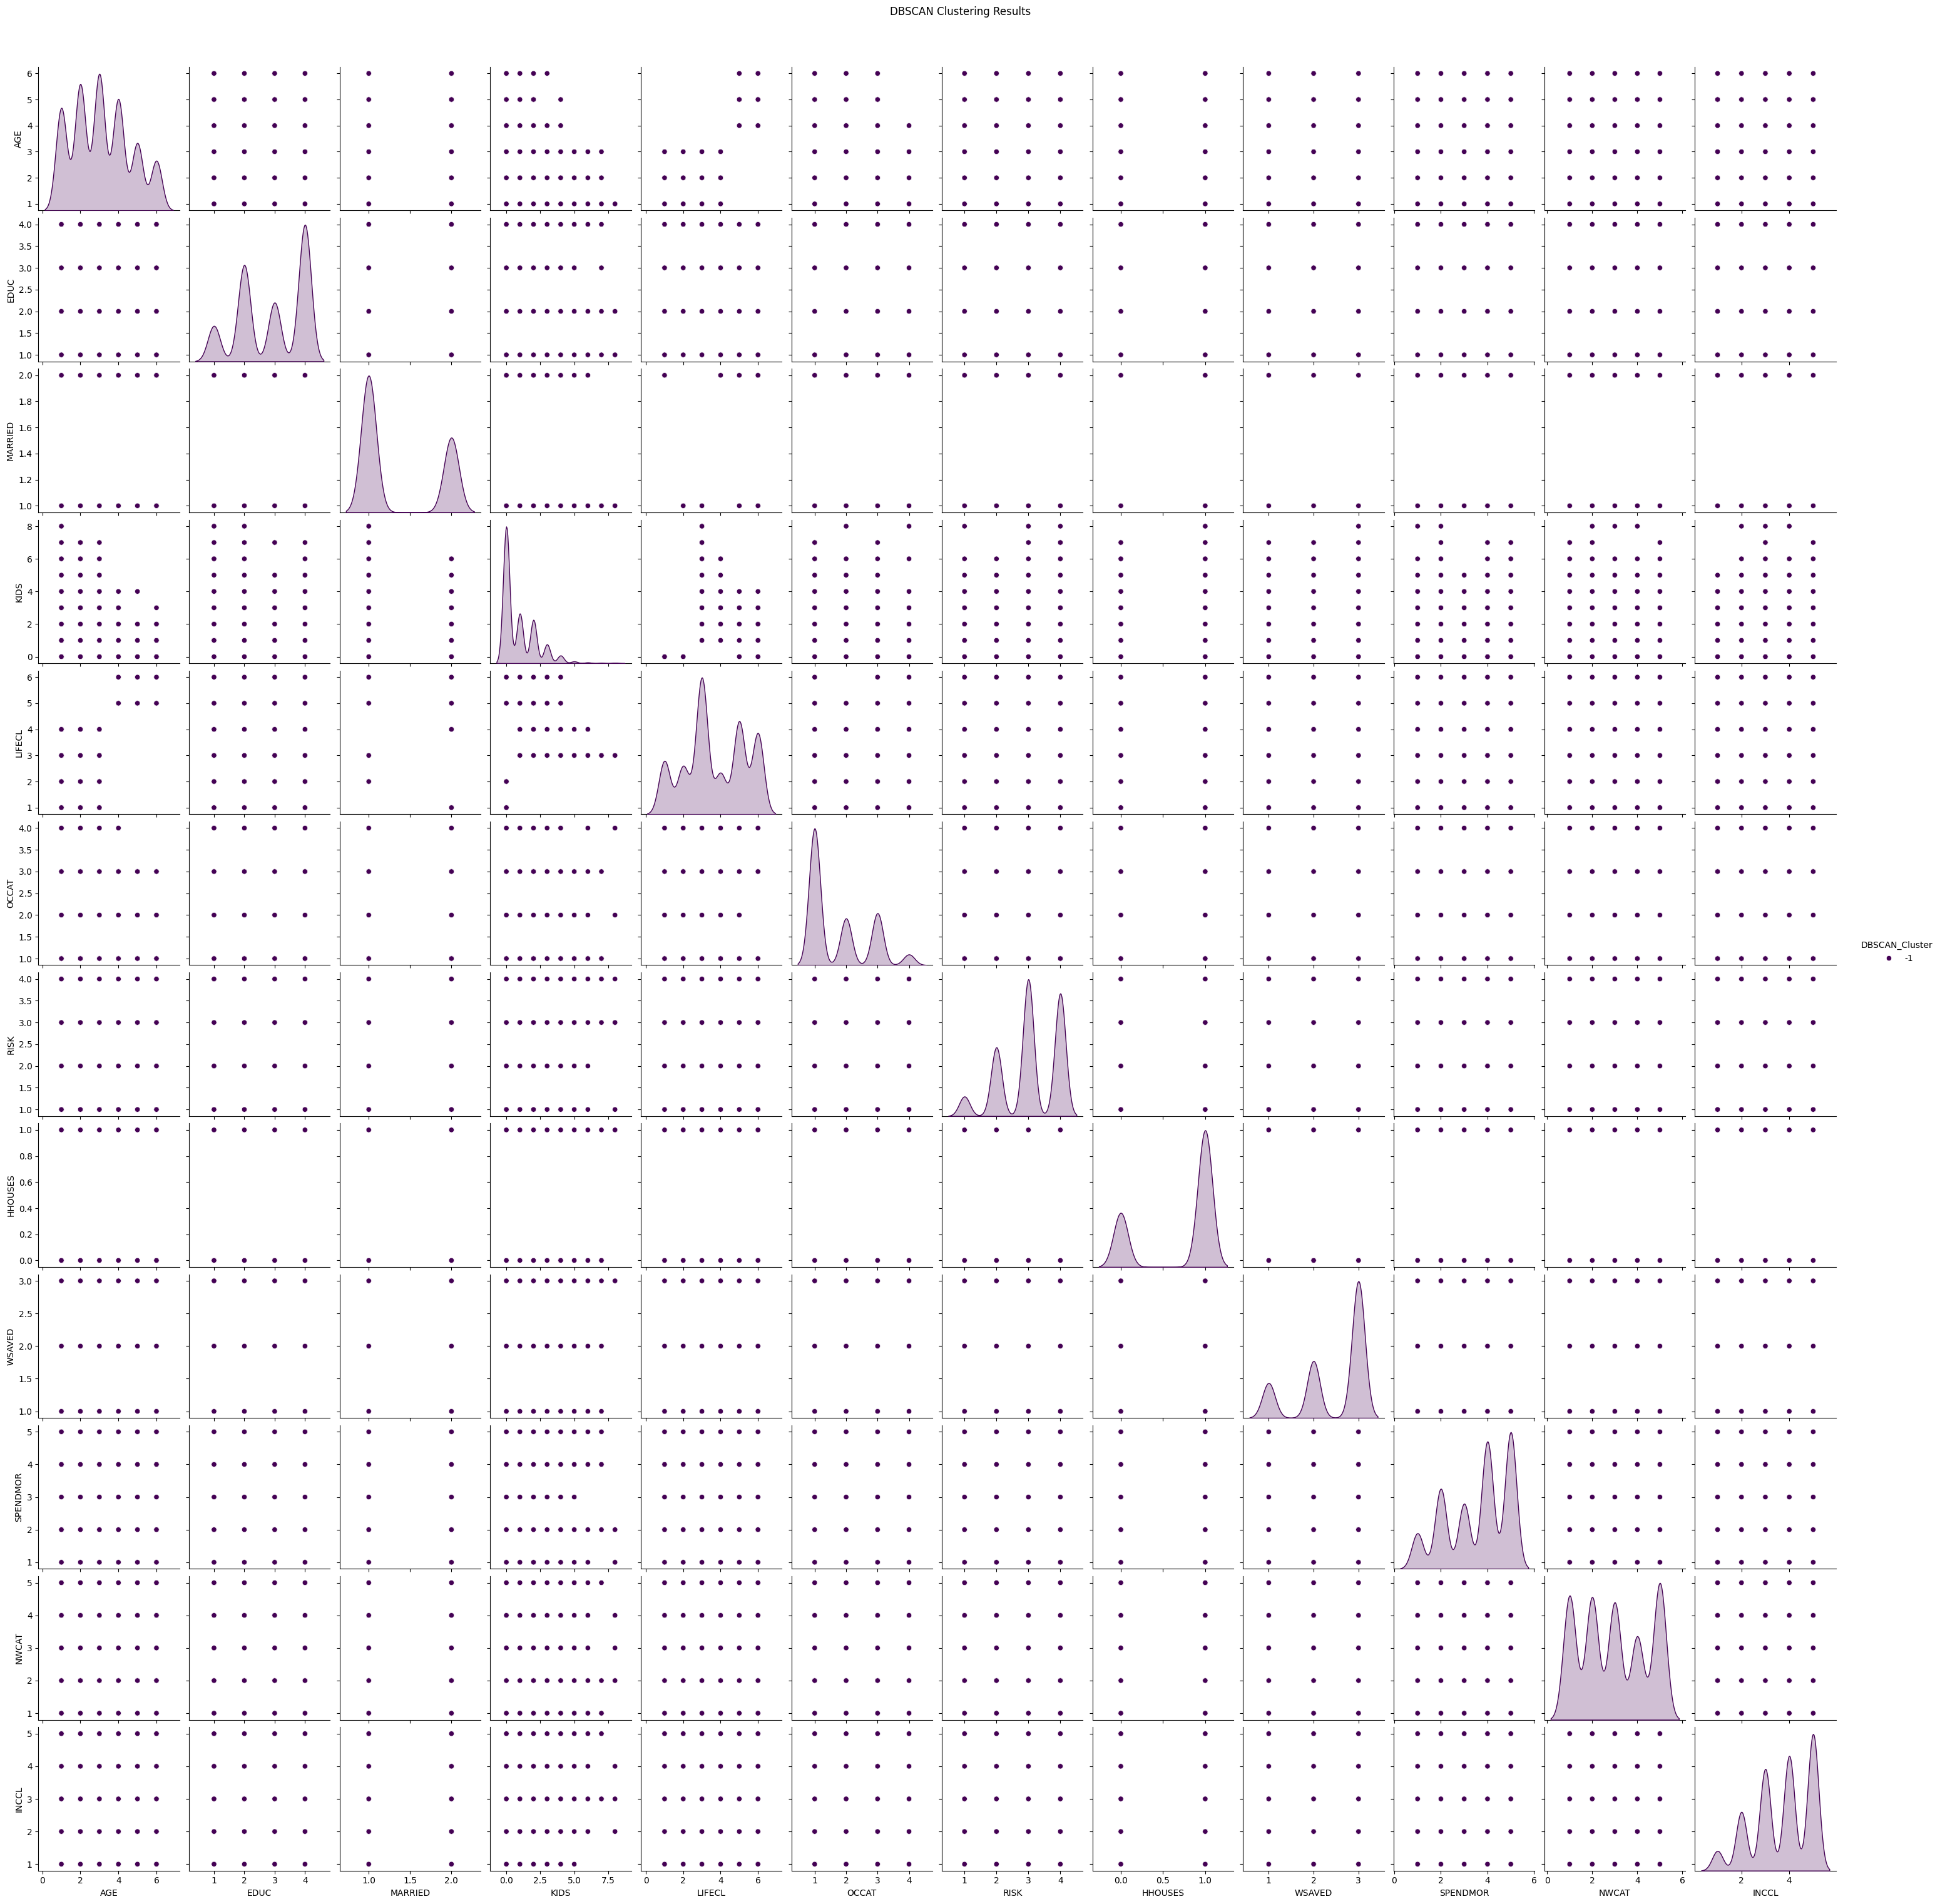


DBSCAN Clustering Results:
   AGE  EDUC  MARRIED  KIDS  LIFECL  OCCAT  RISK  HHOUSES  WSAVED  SPENDMOR  \
0    3     2        1     0       2      1     3        1       1         5   
1    4     4        1     2       5      2     3        0       2         5   
2    3     1        1     2       3      2     2        1       2         4   
3    3     1        1     2       3      2     2        1       2         4   
4    4     3        1     1       5      1     2        1       3         3   

   NWCAT  INCCL  DBSCAN_Cluster  
0      3      4              -1  
1      5      5              -1  
2      4      4              -1  
3      3      4              -1  
4      5      5              -1  


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

dbscan = DBSCAN(eps=0.1, min_samples=100)
dbscan_clusters = dbscan.fit_predict(scaled_data)

data['DBSCAN_Cluster'] = dbscan_clusters

sns.pairplot(data, hue='DBSCAN_Cluster', palette='viridis')
plt.suptitle('DBSCAN Clustering Results', y=1.02)
plt.show()

print("\nDBSCAN Clustering Results:")
print(data.head())

#Part 2


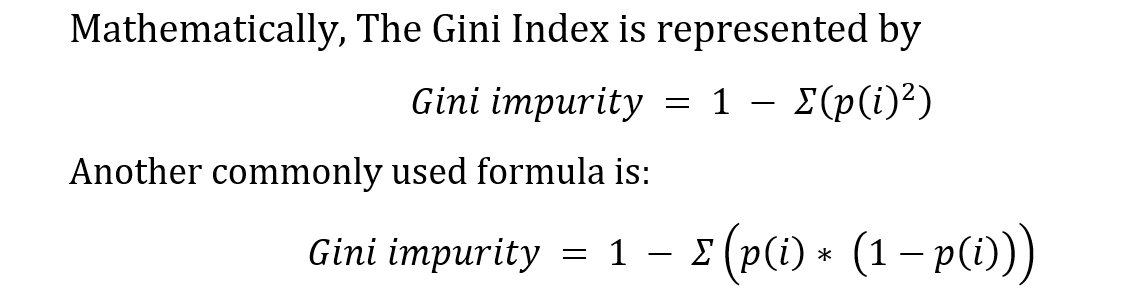

<b>D is the dataset.
n is the number of classes.
𝑝
𝑖
p
i
​
  is the proba bility of selecting a sample belonging to class
𝑖

## Understanding Gini Impurity

### Introduction to Gini Impurity
Gini Impurity is a metric used in decision trees to measure the impurity or disorder of a dataset. It helps in deciding which feature to split on by minimizing impurity.

### Mathematical Definition
The formula for Gini Impurity is:
\[ Gini(D) = 1 - \sum_{i=1}^n (p_i)^2 \]
- \( D \) is the dataset.
- \( n \) is the number of classes.
- \( p_i \) is the probability of selecting a sample belonging to class \( i \).

### Example Calculation

**Let's consider a simple example with a dataset containing two classes, A and B.** The dataset is: [A, A, A, B, B, B, B].

**Step-by-Step Calculation:**





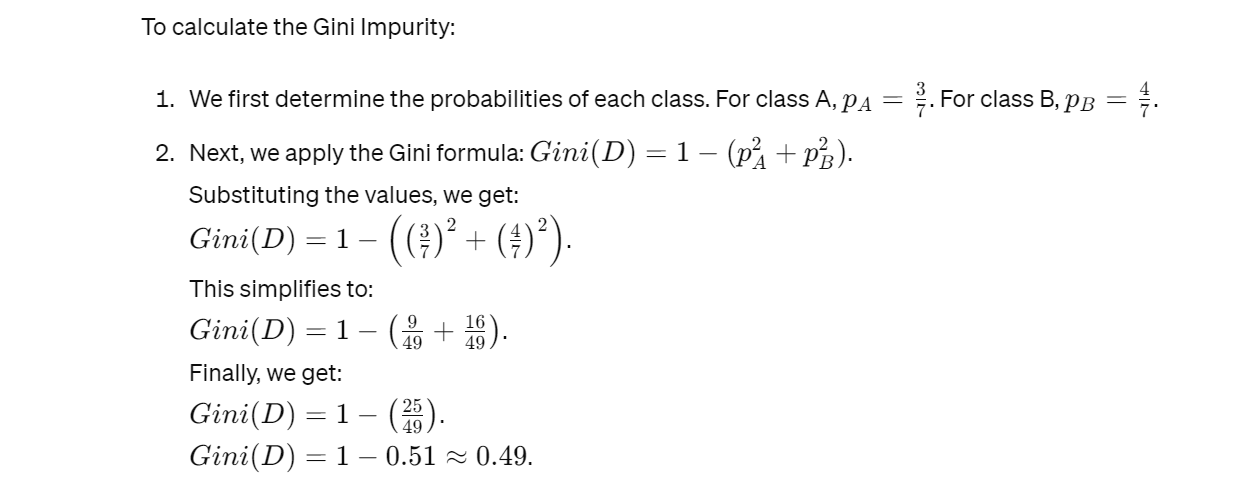

In [ ]:
import numpy as np

labels = ['A', 'A', 'A', 'B', 'B', 'B', 'B']

classes, counts = np.unique(labels, return_counts=True)
probabilities = counts / counts.sum()

gini_impurity = 1 - np.sum(np.square(probabilities))

print(f'Gini Impurity: {gini_impurity}')


Gini Impurity: 0.48979591836734704


In [ ]:
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import numpy as np

X, y = make_classification(n_samples=1000, n_features=10, n_classes=2,
                           weights=[0.9, 0.1], random_state=42)

tree_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
tree_entropy.fit(X, y)

tree_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
tree_gini.fit(X, y)

depth_entropy = tree_entropy.tree_.max_depth
depth_gini = tree_gini.tree_.max_depth

print("Depth of Decision Tree with Entropy Criterion:", depth_entropy)
print("Depth of Decision Tree with Gini Impurity Criterion:", depth_gini)


Depth of Decision Tree with Entropy Criterion: 14
Depth of Decision Tree with Gini Impurity Criterion: 13


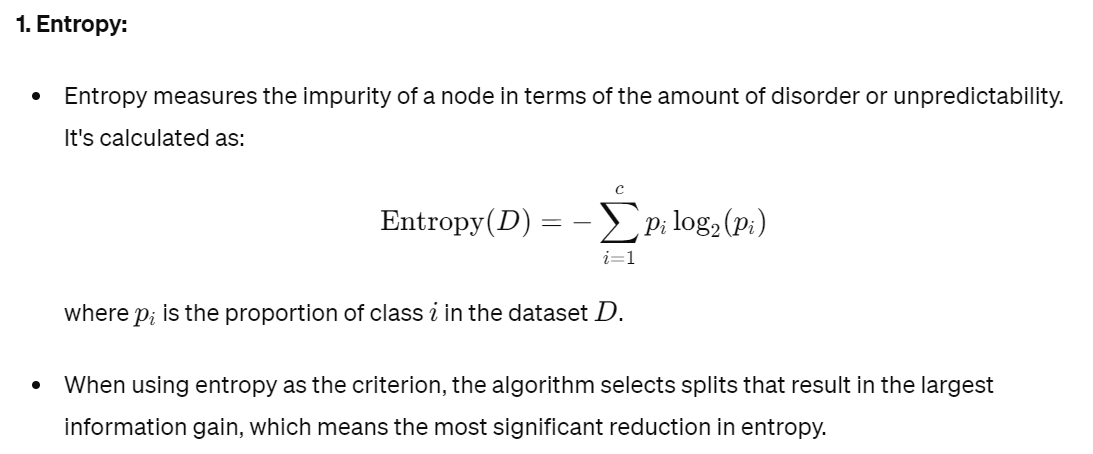

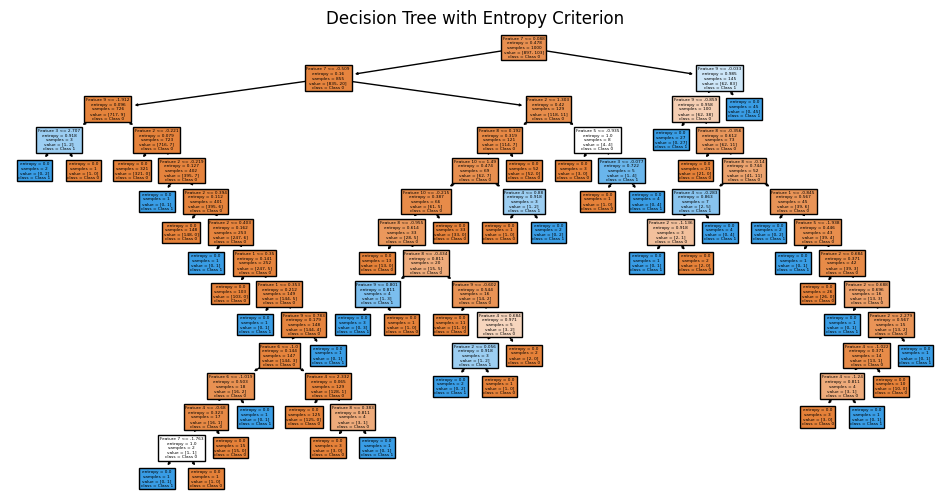

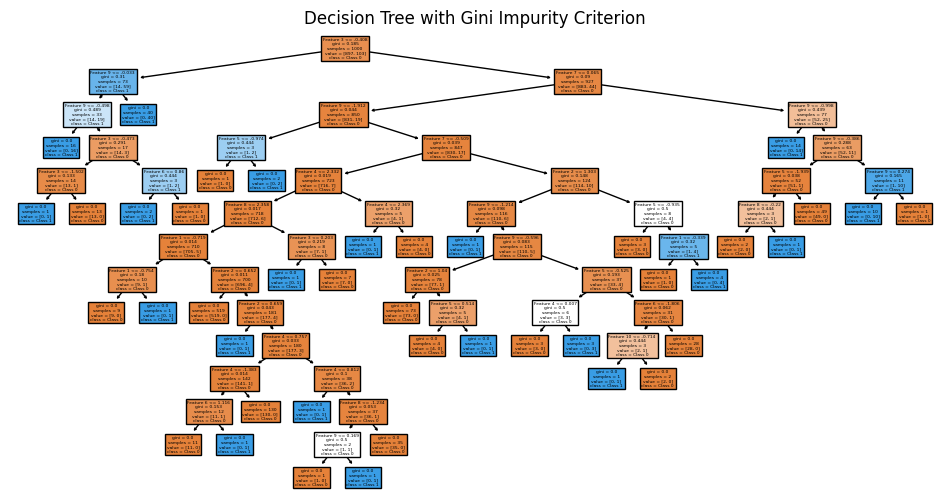

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plot_tree(tree_entropy, filled=True, feature_names=[f'Feature {i}' for i in range(1, 11)], class_names=['Class 0', 'Class 1'])
plt.title('Decision Tree with Entropy Criterion')
plt.show()

plt.figure(figsize=(12, 6))
plot_tree(tree_gini, filled=True, feature_names=[f'Feature {i}' for i in range(1, 11)], class_names=['Class 0', 'Class 1'])
plt.title('Decision Tree with Gini Impurity Criterion')
plt.show()





<b>Sensitivity to Class Distribution</b>:



my data set  has a significant class imbalance (90% vs. 10%). The entropy criterion might be more affected by this imbalance, leading to more splits to handle the minority class better.
The Gini criterion might produce a shallower tree as it might converge faster to a stopping condition due to the dominance of one class.

**Nature of the Criteria:**

Entropy tends to be more sensitive to the distribution of the classes and can lead to more balanced splits, which may result in deeper trees because it might continue splitting to achieve the highest information gain possible.
Gini Impurity, being a simpler measure, often results in splits that lead to slightly less balanced trees but may stop splitting earlier, especially when dealing with highly imbalanced datasets.



#boston_housing


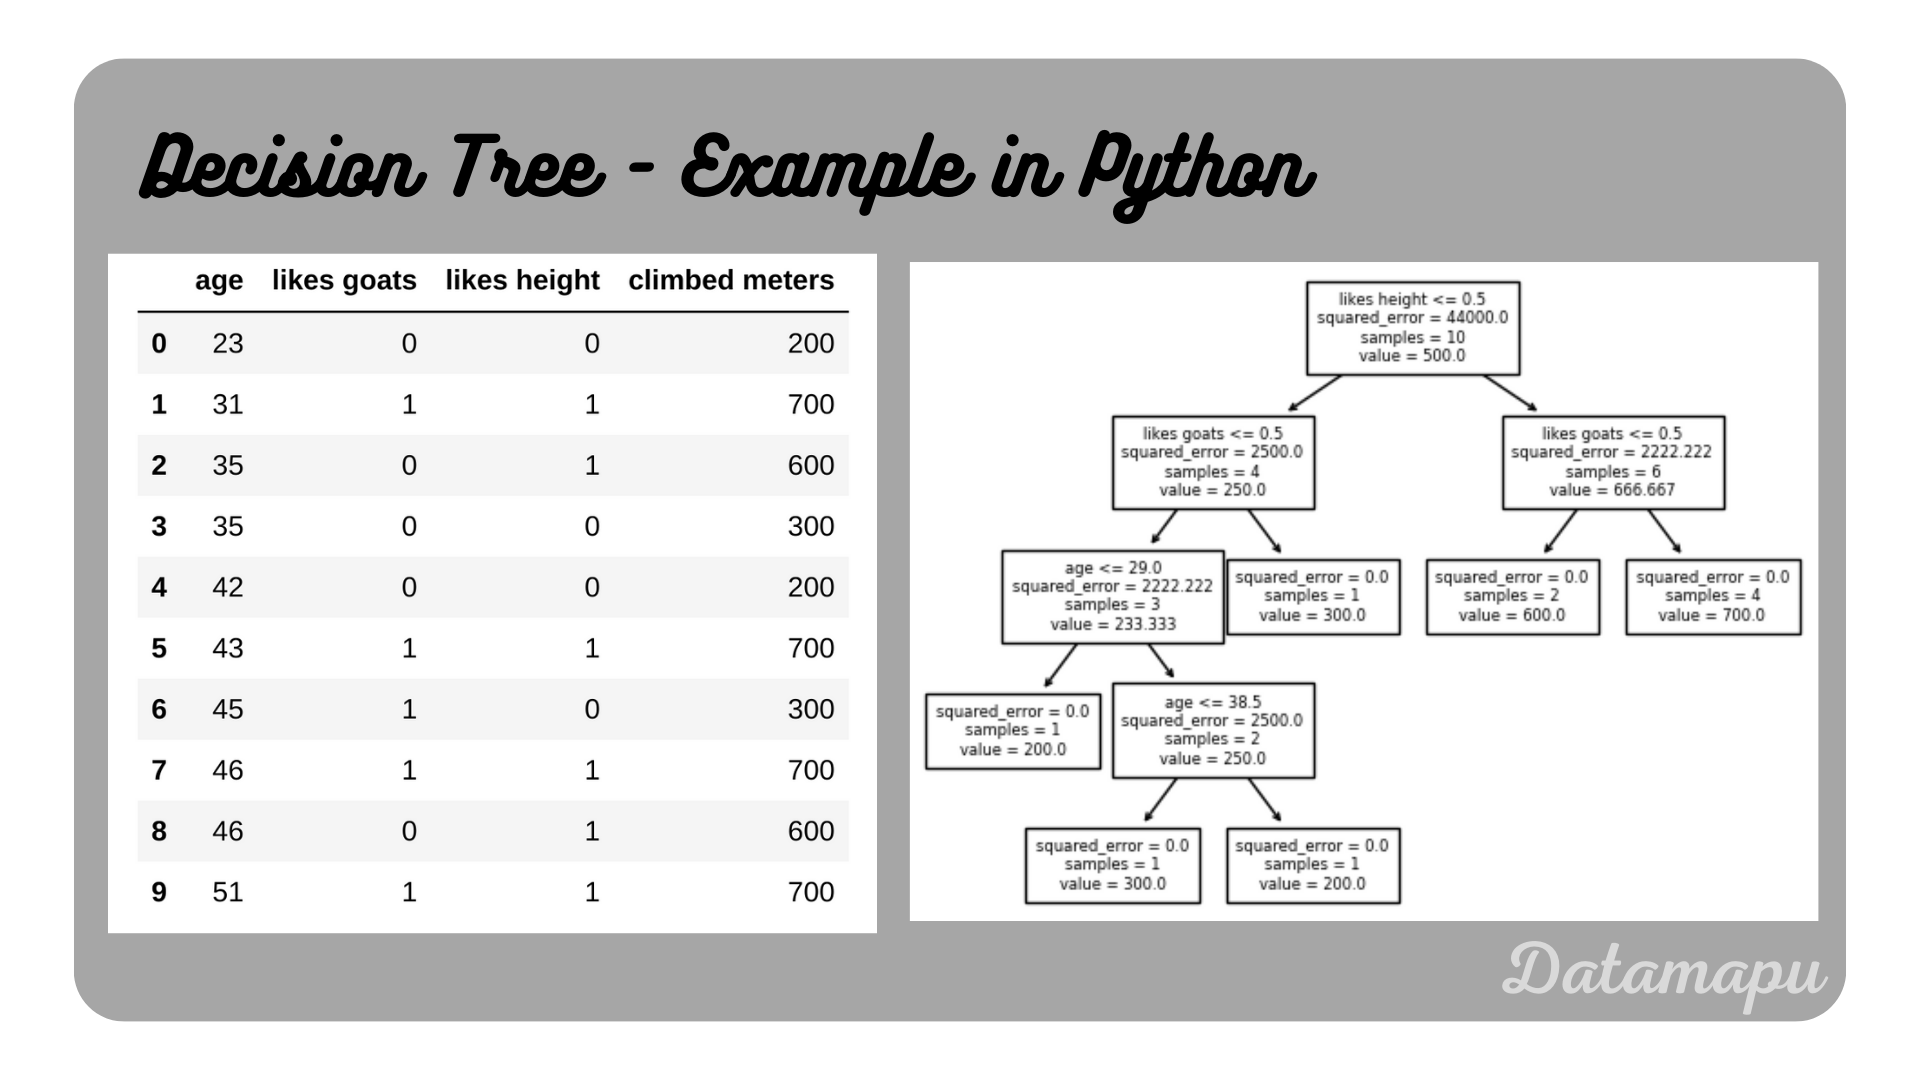

In [ ]:
from sklearn.datasets import fetch_openml
import numpy as np

boston = fetch_openml(data_id=531, as_frame=True)



boston = pd.DataFrame(boston.data, columns=boston.feature_names)
boston.head()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


CRIM    ZN  INDUS CHAS    NOX     RM   AGE     DIS RAD    TAX  PTRATIO  \
0  0.00632  18.0   2.31    0  0.538  6.575  65.2  4.0900   1  296.0     15.3   
1  0.02731   0.0   7.07    0  0.469  6.421  78.9  4.9671   2  242.0     17.8   
2  0.02729   0.0   7.07    0  0.469  7.185  61.1  4.9671   2  242.0     17.8   
3  0.03237   0.0   2.18    0  0.458  6.998  45.8  6.0622   3  222.0     18.7   
4  0.06905   0.0   2.18    0  0.458  7.147  54.2  6.0622   3  222.0     18.7   

        B  LSTAT  
0  396.90   4.98  
1  396.90   9.14  
2  392.83   4.03  
3  394.63   2.94  
4  396.90   5.33

from matplotlib import pyplot as plt
_df_0['CRIM'].plot(kind='hist', bins=20, title='CRIM')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['ZN'].plot(kind='hist', bins=20, title='ZN')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['INDUS'].plot(kind='hist', bins=20, title='INDUS')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['NOX'].plot(kind='hist', bins=20, title='NOX')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='CRIM', y='ZN', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='ZN', y='INDUS', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='INDUS', y='NOX', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='NOX', y='RM', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['DIS']
  ys = series['CRIM']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('DIS', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DIS')
_ = plt.ylabel('CRIM')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['DIS']
  ys = series['ZN']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('DIS', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DIS')
_ = plt.ylabel('ZN')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['DIS']
  ys = series['INDUS']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('DIS', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DIS')
_ = plt.ylabel('INDUS')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['DIS']
  ys = series['NOX']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('DIS', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DIS')
_ = plt.ylabel('NOX')

from matplotlib import pyplot as plt
_df_12['CRIM'].plot(kind='line', figsize=(8, 4), title='CRIM')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['ZN'].plot(kind='line', figsize=(8, 4), title='ZN')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['INDUS'].plot(kind='line', figsize=(8, 4), title='INDUS')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['NOX'].plot(kind='line', figsize=(8, 4), title='NOX')
plt.gca().spines[['top', 'right']].set_visible(False)

<ipython-input-107-56f9ef412134>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(boston['MEDV'], bins=30)


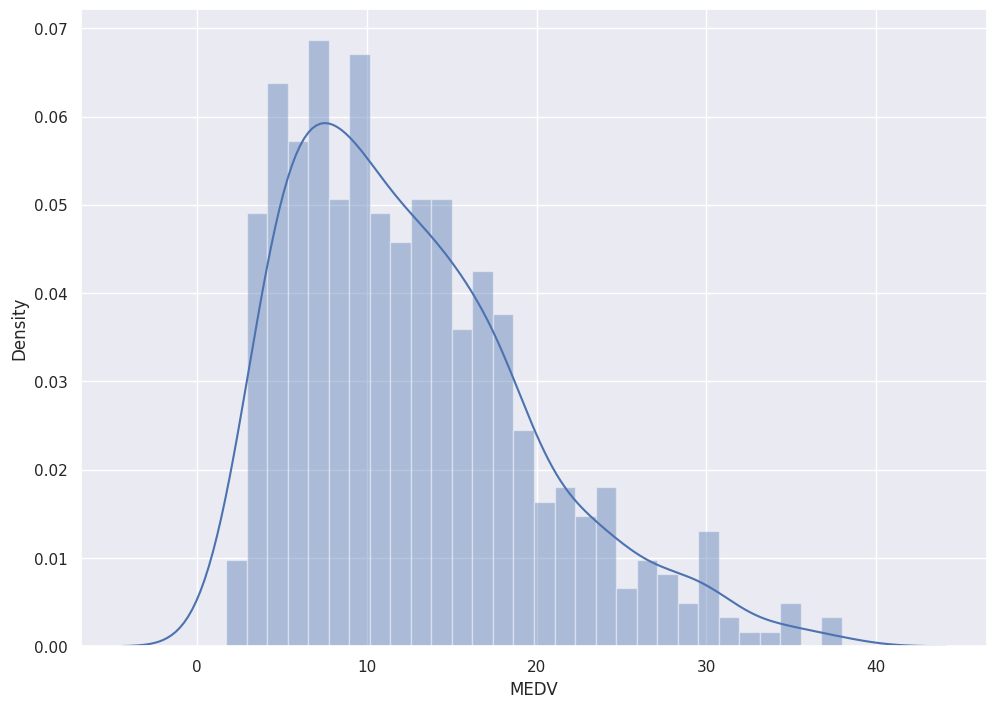

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [ ]:
import pandas as pd
import numpy as np
boston['MEDV'] = boston.iloc[:, -1]

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(boston['MEDV'], bins=30)
plt.show()
boston.isnull().sum()


<Axes: >

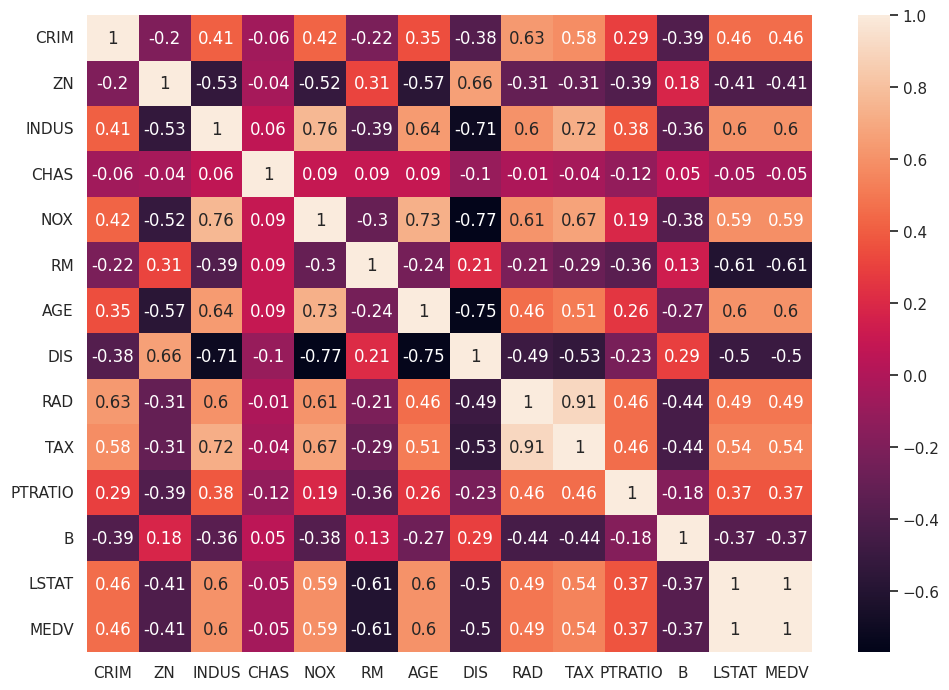

In [ ]:
correlation_matrix = boston.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

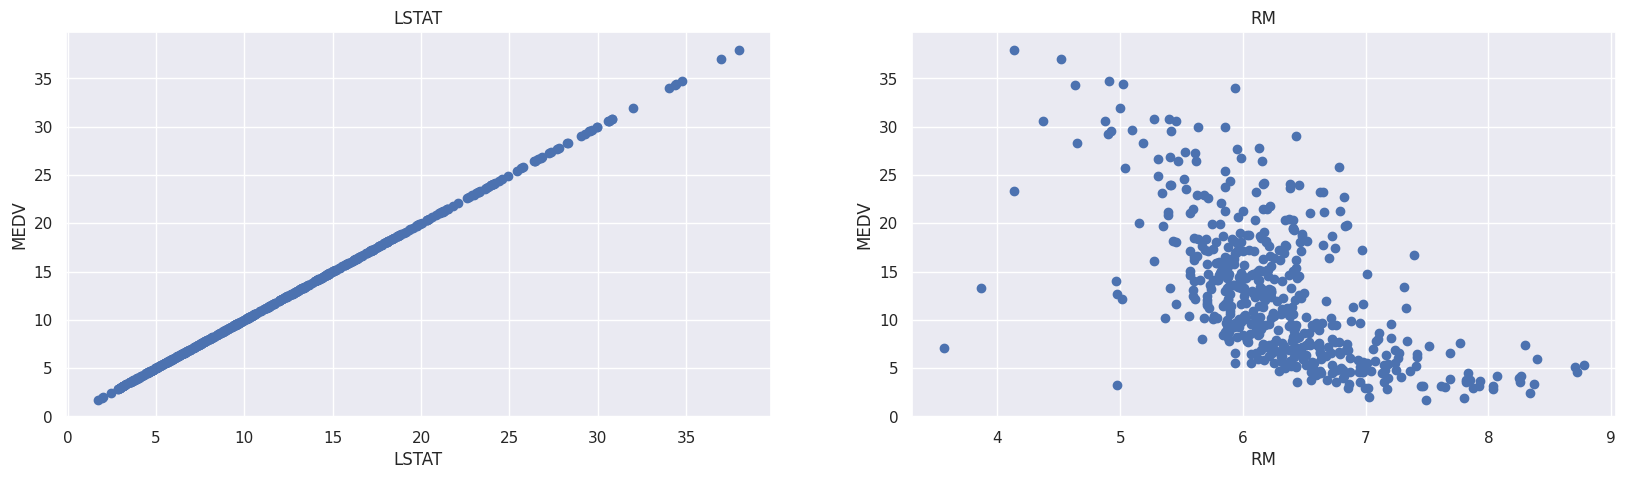

In [ ]:
plt.figure(figsize=(20, 5))

features = ['LSTAT', 'RM']
target = boston['MEDV']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = boston[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

In [ ]:
X = pd.DataFrame(np.c_[boston['LSTAT'], boston['RM']], columns = ['LSTAT','RM'])
Y = boston['MEDV']

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(404, 2)
(102, 2)
(404,)
(102,)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

LinearRegression()

In [ ]:
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 4.6909353718431795e-15
R2 score is 1.0


The model performance for testing set
--------------------------------------
RMSE is 4.71955538663138e-15
R2 score is 1.0


#assignment 1 code


   F1  F2  F3  F4  F5  F6  F7  F8  F9  F10  ...  F86  F87   F88  F89   F90  \
0   1   7   2  29   2   6   0   0   0   81  ...    0   66  6401    4  21.0   
1   1  28   0  42   2   4   0   0   0   14  ...   36   63  3413    4  15.0   
2   1   7   0  42   2   4   0   0   0   10  ...   36   63  3413    4  15.0   
3   1  28   0  42   2   4   0   0   0   11  ...   36   63  3413    4  15.0   
4   2   7   0  42   2   6   0   0   0   13  ...   36   63  3413    4  15.0   

   F91  F92  Target  Unnamed: 93  Unnamed: 94  
0    0    2       2          NaN          NaN  
1   36    1       2          NaN          NaN  
2   36    1       2          NaN          NaN  
3   36    1       2          NaN          NaN  
4   36    1       2          NaN          NaN  

[5 rows x 95 columns]
Best max_depth: 14
Best Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.71      0.72     11504
           1       0.65      0.68      0.67      3

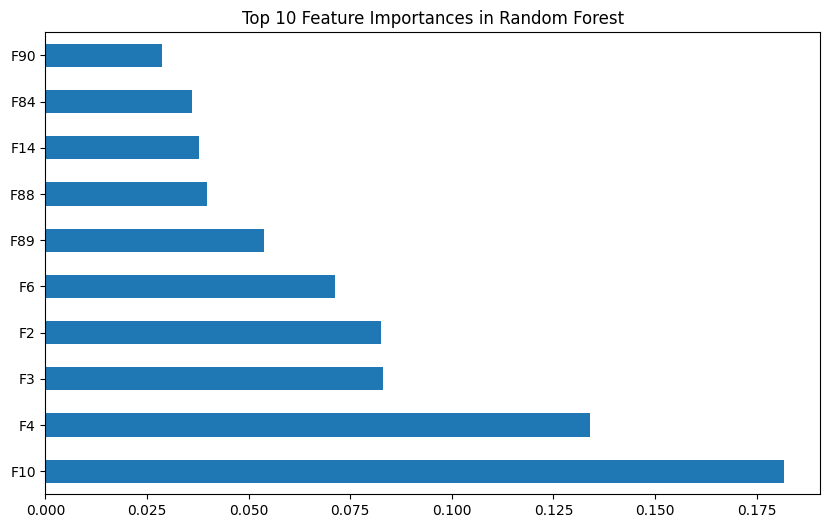

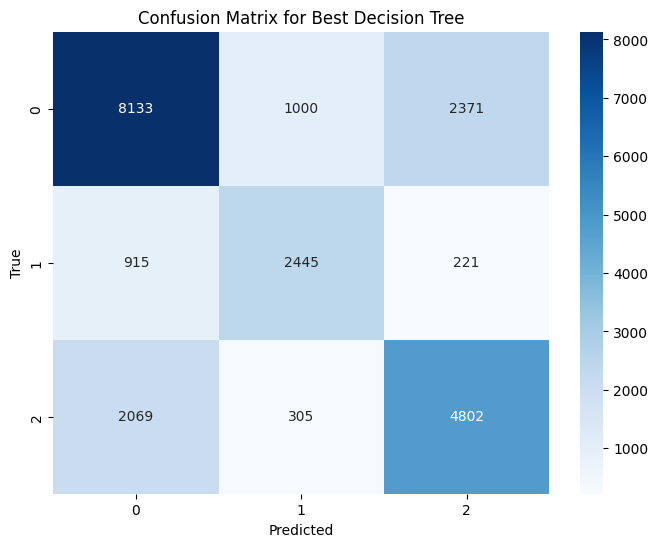

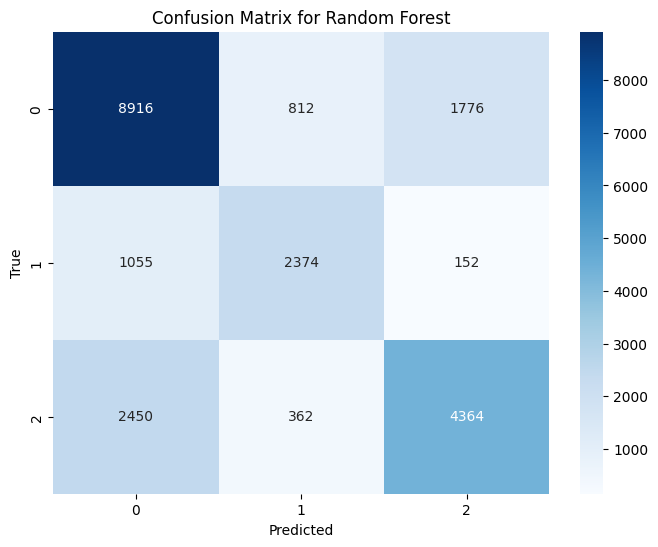

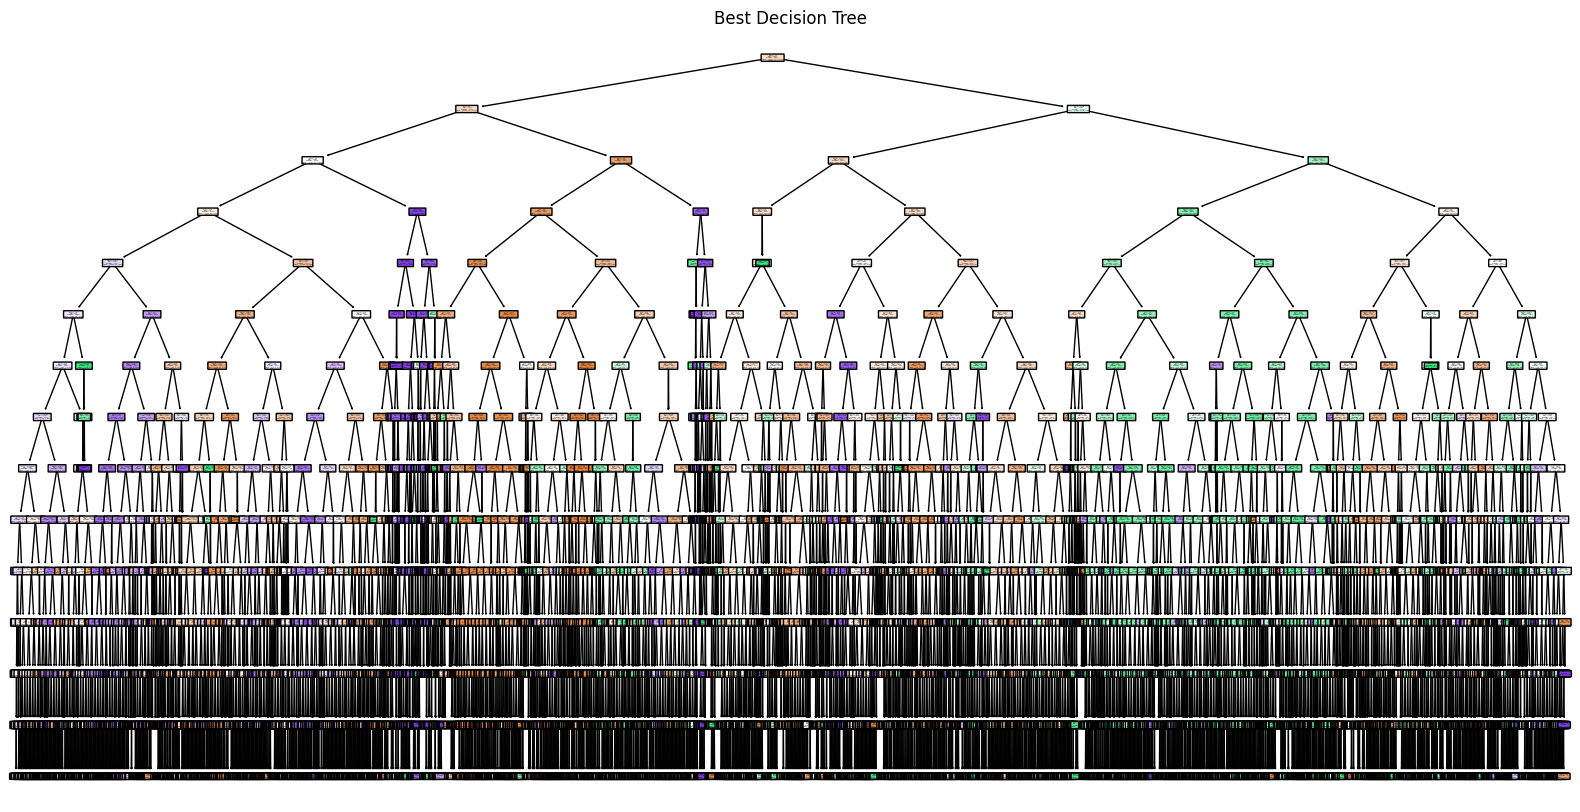

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

file_path = '/content/drive/MyDrive/project 2/Assignment 1-Dataset.csv'
data = pd.read_csv(file_path)

print(data.head())

data = data.drop(['Unnamed: 93', 'Unnamed: 94'], axis=1)

features = data.drop('Target', axis=1)
target = data['Target']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)

feature_importances_rf = pd.Series(random_forest.feature_importances_, index=features.columns)
top_features = feature_importances_rf.nlargest(10).index



param_grid = {'max_depth': range(1, 21)}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_tree = grid_search.best_estimator_
print(f"Best max_depth: {grid_search.best_params_['max_depth']}")

y_pred_dt = best_tree.predict(X_test_top)

print("Best Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

y_pred_rf = random_forest.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

plt.figure(figsize=(10, 6))
feature_importances_rf.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances in Random Forest')
plt.show()

conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Best Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

plt.figure(figsize=(20, 10))
plot_tree(best_tree, filled=True, feature_names=top_features, class_names=target.unique().astype(str), rounded=True)
plt.title('Best Decision Tree')
plt.show()


# Part 3

In [ ]:
!pip install qiskit==0.46
!pip install pylatexenc==2.7
!pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.8/157.8 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.7-py3-none-any.whl size=130757 sha256=39d31a41741da8c3e8050fb22c5863208dda3e42550ffd84da0e653f930ba95a
  Stored in directory: /root/.cache/pip/wheels/55/5e/bf/f7bc2fdf17af8585f4462afb89d69b632f829b9d87c4ea653a
Successfully built pylatexenc
     ━━━━━━━━━━━━━━━

#[A]

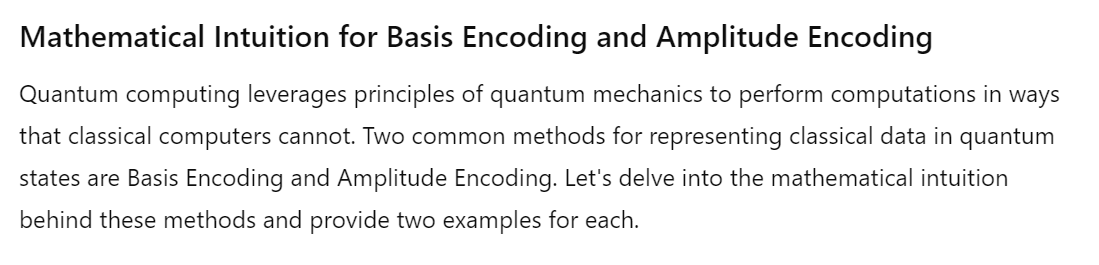

**Basis** **Encoding**
**Intuition**:
Basis Encoding is a straightforward method where each classical bit string is directly mapped to a corresponding quantum basis state. This encoding allows us to represent binary data as quantum states.

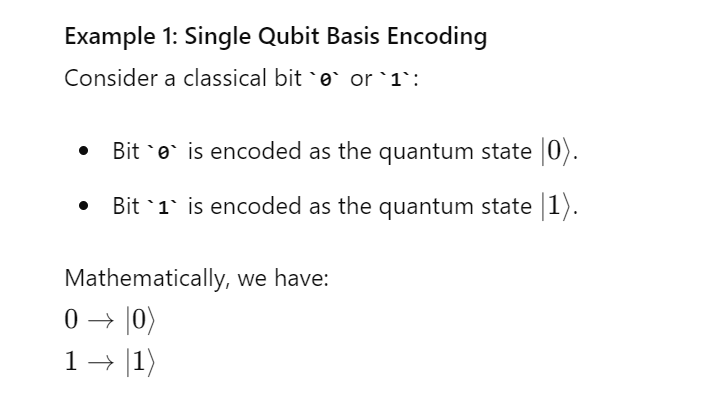

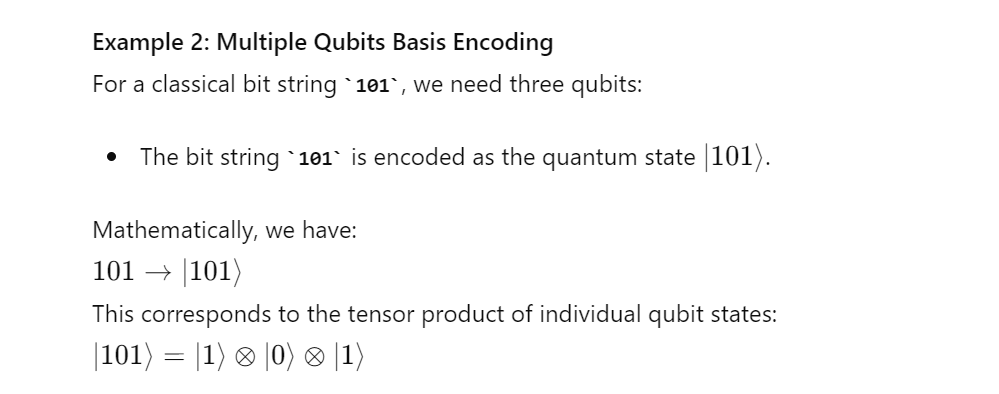

State vector for Basis Encoding '101': Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))


<ipython-input-9-580656eda714>:19: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc_basis, backend).result()
<ipython-input-9-580656eda714>:27: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc_basis, backend=Aer.get_backend('qasm_simulator')).result()


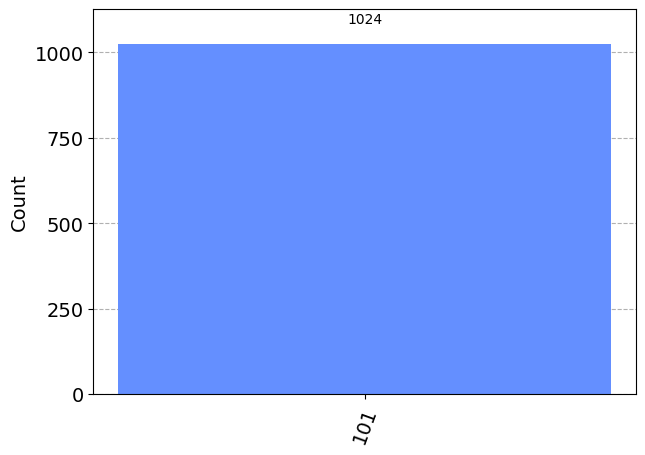

In [ ]:
from qiskit import QuantumCircuit, Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram


qc_basis = QuantumCircuit(3)

qc_basis.x(0)
qc_basis.x(2)

qc_basis.draw('mpl')

backend = Aer.get_backend('statevector_simulator')
result = execute(qc_basis, backend).result()
statevector = result.get_statevector()

print("State vector for Basis Encoding '101':", statevector)

qc_basis.measure_all()
result = execute(qc_basis, backend=Aer.get_backend('qasm_simulator')).result()
counts = result.get_counts()

plot_histogram(counts)


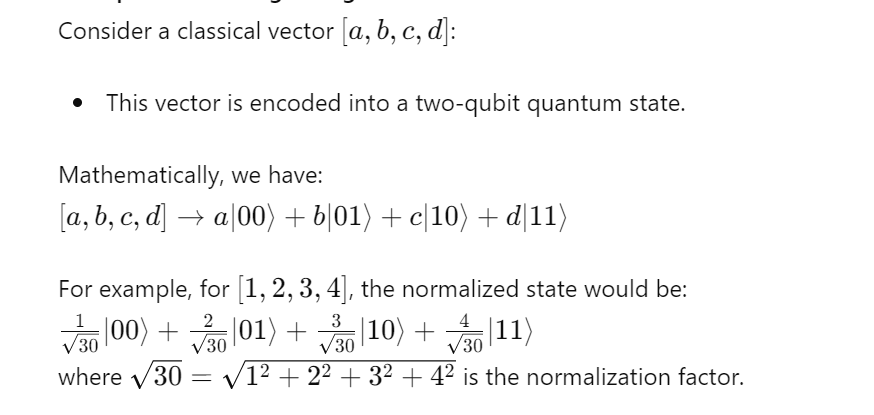

<ipython-input-8-06bd67087766>:17: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc_amplitude, backend).result()
<ipython-input-8-06bd67087766>:22: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc_amplitude, backend=Aer.get_backend('qasm_simulator')).result()


State vector for Amplitude Encoding [1, 2, 3, 4]: Statevector([0.18257419+0.j, 0.36514837+0.j, 0.54772256+0.j,
             0.73029674+0.j],
            dims=(2, 2))


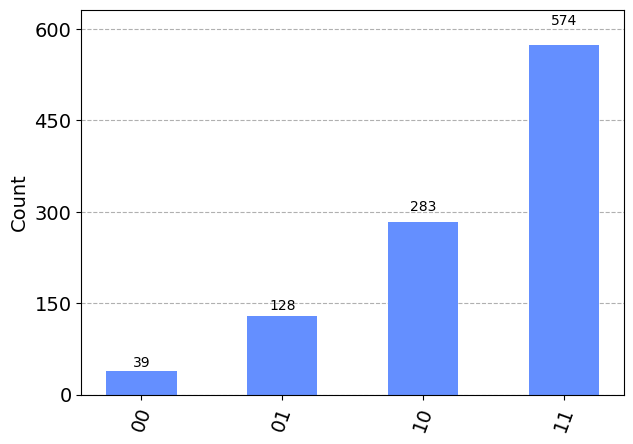

In [ ]:
from qiskit import QuantumCircuit, Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit



vector = np.array([1, 2, 3, 4])
norm = np.linalg.norm(vector)
normalized_vector = vector / norm

qc_amplitude = QuantumCircuit(2)
qc_amplitude.initialize(normalized_vector, [0, 1])
qc_amplitude.draw('mpl')

backend = Aer.get_backend('statevector_simulator')
result = execute(qc_amplitude, backend).result()
statevector = result.get_statevector()
print("State vector for Amplitude Encoding [1, 2, 3, 4]:", statevector)

qc_amplitude.measure_all()
result = execute(qc_amplitude, backend=Aer.get_backend('qasm_simulator')).result()
counts = result.get_counts()
plot_histogram(counts)


**Basis** **Encoding**:
Simplicity: Direct and simple, each bit maps to a quantum state.

*   Simplicity: Direct and simple, each bit maps to a quantum state.

*   Space: Requires more qubits for larger bit strings.


*  Use Case: Often used when the data is inherently binary or when simplicity is preferred over compactness.


**Amplitude Encoding:**

* Compactness: Can represent large vectors with fewer qubits.
* Complexity: Requires careful normalization and manipulation of amplitudes.
* Use Case: Useful in quantum machine learning and scenarios where representing large datasets compactly is beneficia

#[B]

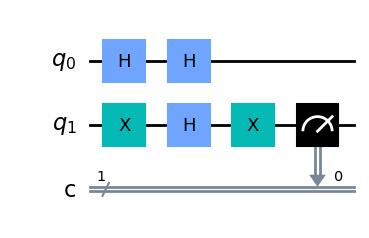

In [ ]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram

qc = QuantumCircuit(2, 1)

qc.h(0)
qc.h(0)

qc.x(1)
qc.h(1)
qc.x(1)

qc.measure(1, 0)


qc.draw('mpl')



<ipython-input-21-ef986f79fc0a>:3: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc, backend, shots=1024).result()


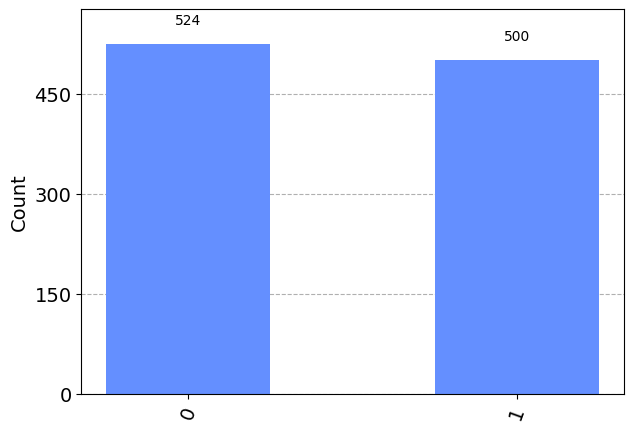

In [ ]:
# Simulate the circuit
backend = Aer.get_backend('qasm_simulator')
result = execute(qc, backend, shots=1024).result()
counts = result.get_counts()

# Plot the measurement results
plot_histogram(counts)